## ALE plots

In [1]:
import sys
sys.path

['c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [2]:
alepath="C:\D_Drive\Indra\github_projects\explainability\PyALE-master"
sys.path.insert(0,alepath)
sys.path

['C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master',
 'c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [3]:
from PyALE import ale, ALE_1D_IS, ALE_1D, ALE_2D, lib

In [4]:
ALE_1D_IS.fn_check()

# PyALE: Usage examples

In [5]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

## Prepare Data

In [6]:
# get the raw diamond data (from R's ggplot2)
# dat_diamonds = pd.read_csv(
#     "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
# )
dat_diamonds = pd.read_csv(".\Input_Data\diamonds.csv")
dat_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [7]:
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()
y = dat_diamonds["price"].copy()

In [8]:
X = X_raw.copy()
# convert the three text columns to ordered categoricals
X["cut"] = X["cut"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True
    )
)
X["clarity"] = X["clarity"].astype(
    pd.api.types.CategoricalDtype(
        categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
        ordered=True,
    )
)

In [9]:
# use the codes of each categorical as a numeric encoding for the feature
X["cut_code"] = X["cut"].cat.codes
X["clarity_code"] = X["clarity"].cat.codes

In [10]:
# fit a one-hot-encoder before the function
# it is important to use a one-hot-encoder, that is fitted with all possible
# categories in the feature.
one_hot_encoder = OneHotEncoder().fit(X[["color"]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [11]:
coded_feature = onehot_encode(X[["color"]])
X = pd.concat([X, coded_feature], axis=1)

In [12]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code,D,E,F,G,H,I,J
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
features = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features = features + coded_feature.columns.to_list()

In [14]:
X[features].head()

,carat,cut_code,clarity_code,depth,table,x,y,z,D,E,F,G,H,I,J
0,0.23,4,1,61.5,55.0,3.95,3.98,2.43,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,3,2,59.8,61.0,3.89,3.84,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1,4,56.9,65.0,4.05,4.07,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3,3,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,1,1,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit the model

In [15]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

# aleplot_1D_continuous(X, model, feature, grid_size=20, include_CI=True, C=0.95)

In [16]:
ale1d_IS_df = ALE_1D_IS.aleplot_1D_continuous(X=X[features], model=model, feature="carat", grid_size=5, include_CI=True, C=0.95, verbose=True)

2024-04-25 23:14:51.505 | INFO     | PyALE._src.ALE_1D_IS:aleplot_1D_continuous:52 - Starting of aleplot_1D_continuous
2024-04-25 23:14:51.507 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_continuous:53 - Start: Data types check of the function
2024-04-25 23:14:51.508 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_continuous:60 - End: Data types check of the function
2024-04-25 23:14:51.510 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_continuous:62 - quantiles count:6,quantiles:[0.  0.2 0.4 0.6 0.8 1. ]
2024-04-25 23:14:51.513 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_continuous:65 - type(X[feature]):<class 'pandas.core.series.Series'>
2024-04-25 23:14:51.517 | INFO     | PyALE._src.lib:quantile_ied:146 - Starting of quantile_ied
2024-04-25 23:14:51.519 | DEBUG    | PyALE._src.lib:quantile_ied:147 - type(x_vec):<class 'pandas.core.series.Series'>,x_vec[:5]:0    0.23
1    0.21
2    0.23
3    0.29
4    0.31
Name: carat, dtype: float64
2024-04-25 23:14:51.526 | DEBUG    | PyALE._src.lib:q

In [17]:
ale1d_IS_df.head(10)

,local_mean_effects,size_original,Accumulated_local_mean_effects,size,Weight,mid_point_of_two_consecutive_acuumulated_local_mean_effects,proportional_weight,proportional_weight_times_mid_point_of_two_consecutive_acuumulated_local_mean_effects,weighted_mean_of_accumulated_local_mean_effects,Weighted_mean_centered_ALE,eff,CI_estimate,lowerCI_95%_local_mean_effects,upperCI_95%_local_mean_effects,lowerCI_95%_Accumulated_local_mean_effects,upperCI_95%_Accumulated_local_mean_effects,lowerCI_95%_Weighted_mean_centered_ALE,upperCI_95%_Weighted_mean_centered_ALE,lowerCI_95%,upperCI_95%
carat,,,,,,,,,,,,,,,,,,,,
0.20,0.000000,0.0,0.000000,0.0,11058.0,45.733177,0.205006,9.375556,1746.341588,-1746.341588,-1746.341588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.35,91.466354,11058.0,91.466354,11058.0,10527.0,286.877285,0.195161,55.987341,1746.341588,-1654.875234,-1654.875234,2.354948,89.111406,93.821302,89.111406,93.821302,-1657.230182,-1652.520287,-1657.230182,-1652.520287
0.53,390.821861,10527.0,482.288215,10527.0,12017.0,1191.203578,0.222785,265.381783,1746.341588,-1264.053373,-1264.053373,4.960466,385.861396,395.782327,477.327750,487.248681,-1269.013839,-1259.092908,-1269.013839,-1259.092908
0.90,1417.830726,12017.0,1900.118941,12017.0,9651.0,2549.378069,0.178921,456.137333,1746.341588,153.777353,153.777353,6.775972,1411.054754,1424.606697,1893.342969,1906.894913,147.001381,160.553324,147.001381,160.553324
1.13,1298.518257,9651.0,3198.637197,9651.0,10687.0,4842.635865,0.198128,959.459575,1746.341588,1452.295609,1452.295609,19.571237,1278.947020,1318.089493,3179.065961,3218.208434,1432.724372,1471.866846,1432.724372,1471.866846
5.01,3287.997335,10687.0,6486.634532,10687.0,0.0,3243.317266,0.000000,0.000000,1746.341588,4740.292944,4740.292944,54.057224,3233.940110,3342.054559,6432.577308,6540.691756,4686.235720,4794.350168,4686.235720,4794.350168


In [18]:
ale1d_df = ALE_1D.aleplot_1D_continuous(X=X[features], model=model, feature="carat", grid_size=5, include_CI=True, C=0.95)

In [19]:
ale1d_df.head(10)

,eff,size,lowerCI_95%,upperCI_95%
carat,,,,
0.20,-1746.341588,0.0,NaN,NaN
0.35,-1654.875234,11058.0,-1657.230182,-1652.520287
0.53,-1264.053373,10527.0,-1269.013839,-1259.092908
0.90,153.777353,12017.0,147.001381,160.553324
1.13,1452.295609,9651.0,1432.724372,1471.866846
5.01,4740.292944,10687.0,4686.235720,4794.350168


In [20]:
ale1d_IS_df.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]].head(10)

,eff,size,lowerCI_95%,upperCI_95%
carat,,,,
0.20,-1746.341588,0.0,NaN,NaN
0.35,-1654.875234,11058.0,-1657.230182,-1652.520287
0.53,-1264.053373,10527.0,-1269.013839,-1259.092908
0.90,153.777353,12017.0,147.001381,160.553324
1.13,1452.295609,9651.0,1432.724372,1471.866846
5.01,4740.292944,10687.0,4686.235720,4794.350168


2024-04-25 23:14:55.653 | INFO     | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff:406 - Starting of plot_1D_continuous_eff
2024-04-25 23:14:55.657 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff:407 - res_df.shape:(6, 4), res_df.head():               eff     size  lowerCI_95%  upperCI_95%
carat                                                
0.20  -1746.341588      0.0          NaN          NaN
0.35  -1654.875234  11058.0 -1657.230182 -1652.520287
0.53  -1264.053373  10527.0 -1269.013839 -1259.092908
0.90    153.777353  12017.0   147.001381   160.553324
1.13   1452.295609   9651.0  1432.724372  1471.866846
2024-04-25 23:14:55.667 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff:408 - X.shape:(53940, 18), X.head():   carat      cut color clarity  depth  table     x     y     z  cut_code  \
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43         4   
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31         3   
2   0.23     Good     E     VS

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': '1D ALE Plot - Continuous'}, xlabel='carat', ylabel='Effect on prediction (centered)'>)

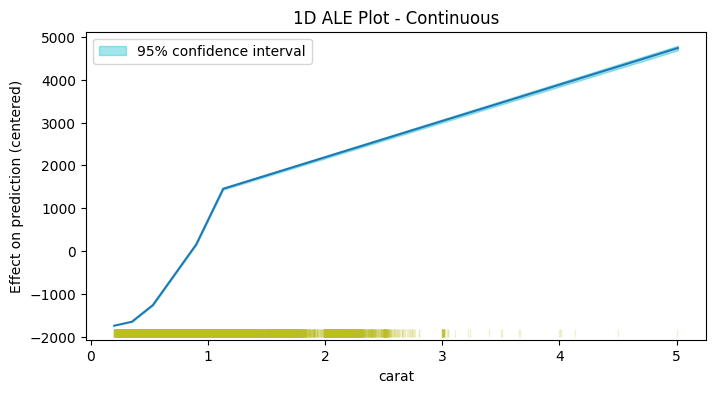

In [21]:
ALE_1D_IS.plot_1D_continuous_eff(ale1d_IS_df.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]], X, fig=None, ax=None, verbose=True)

2024-04-25 23:16:22.491 | INFO     | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff2:490 - Starting of plot_1D_continuous_eff
2024-04-25 23:16:22.495 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff2:491 - res_df.shape:(6, 4), res_df.head():               eff     size  lowerCI_95%  upperCI_95%
carat                                                
0.20  -1746.341588      0.0          NaN          NaN
0.35  -1654.875234  11058.0 -1657.230182 -1652.520287
0.53  -1264.053373  10527.0 -1269.013839 -1259.092908
0.90    153.777353  12017.0   147.001381   160.553324
1.13   1452.295609   9651.0  1432.724372  1471.866846
2024-04-25 23:16:22.503 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_continuous_eff2:492 - X.shape:(53940, 18), X.head():   carat      cut color clarity  depth  table     x     y     z  cut_code  \
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43         4   
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31         3   
2   0.23     Good     E    

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': '1D ALE Plot - Continuous'}, xlabel='carat', ylabel='Effect on prediction (centered)'>)

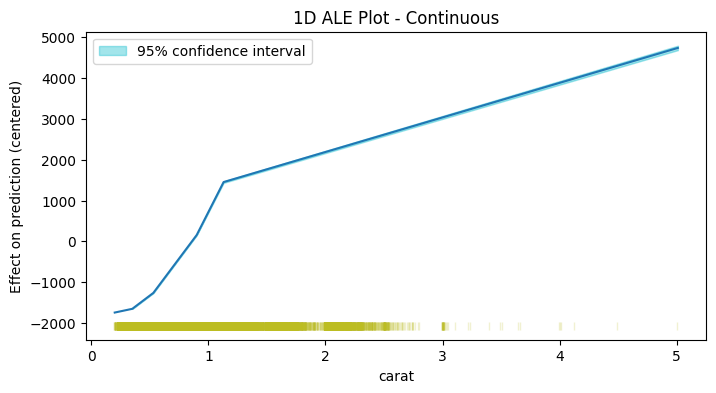

In [25]:
ALE_1D_IS.plot_1D_continuous_eff2(ale1d_IS_df.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]], X, gap=0.5, fig=None, ax=None, verbose=True)

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': '1D ALE Plot - Continuous'}, xlabel='carat', ylabel='Effect on prediction (centered)'>)

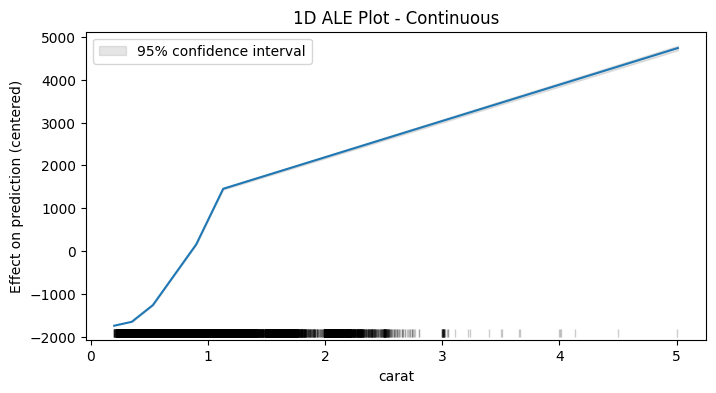

In [ ]:
ALE_1D.plot_1D_continuous_eff(ale1d_df, X, fig=None, ax=None)

In [ ]:
from PyALE import ale

### continuous feature

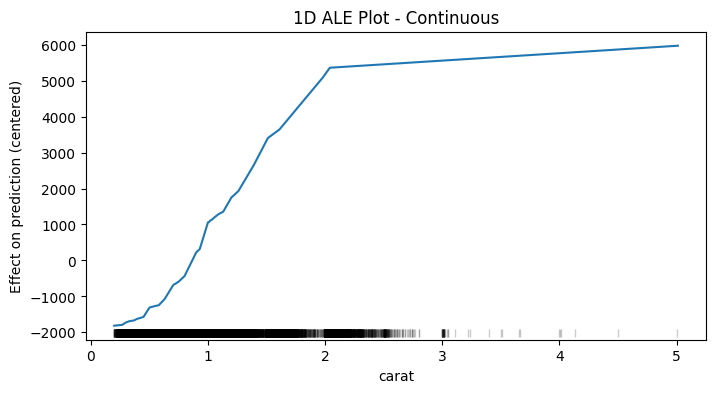

In [17]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X[features], model=model, feature=["carat"], grid_size=50, include_CI=False
)

### continuous feature with confidence interval

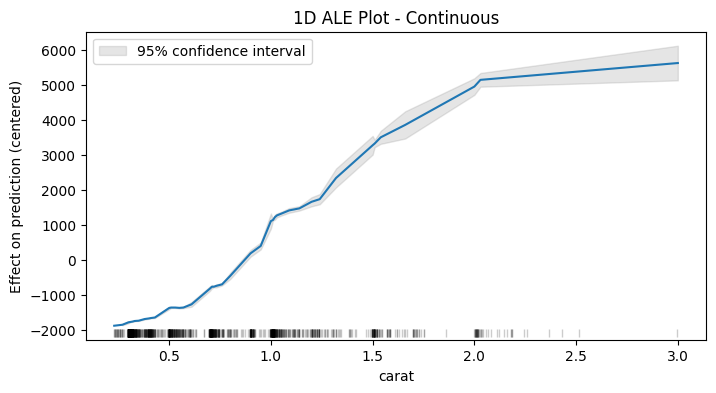

In [18]:
## 1D - continuous - with 95% CI
random.seed(123)
X_sample = X[features].loc[random.sample(X.index.to_list(), 1000), :]
ale_eff = ale(
    X=X_sample, model=model, feature=["carat"], grid_size=50, include_CI=True, C=0.95
)